# **STAGE PONTS INSTRUMENTES - Notebook 10**

## Table of Contents

### 0. [Bibliothèques](#0/-Bibliothèques)
### I. [Création d'ensembles](#I/-Création-d'ensembles)
### II. [Calcul de l'énergie](#II/-Calcul-de-l'énergie)
1. [Interpolation des LI avec les vitesses](#III.1-Calcul-des-LI)
2. [Energie des signaux en fonction de la vitesse](#II.2-Energie-des-signaux-en-fonction-de-la-vitesse-(en-m/s))
3. [Interpolation de cette fonction (énergie/metres)](#II.3-Interpolation-de-cette-fonction-(énergie/metres))
4. [LI en fonction des vitesses (avec la fonction interpolée](#II.4-LI-en-fonction-des-vitesses-(avec-la-fonction-interpolée))

### III. [Autres test](#III/-Autres-tests)



**Dans ce Notebook, nous allons voir si nous pouvons constater une sorte de conservation de l'énergie telle que :**
**E = $$
\sqrt{aire(s²)} 
$$**
avec s le signal

**Nous verrons par la suite les premières observations sur l'interpolation des lignes d'influence avec les vitesses**

## 0/ Bibliothèques

In [1]:
from Bwifsttar import load_senlis_modified,calibration_mt,lignes_influence_mt_speed
import numpy as np
from scipy.interpolate import interp1d
from Previous_files.interpolation_LI import compare_weights
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from Bwifsttar import estimation


## I/ Création d'ensembles

In [2]:
calibration_trucks,traffic_trucks = load_senlis_modified(selected=6) #[3,4,6,7]

def gather_trucks(calibration_trucks,traffic_trucks):
    """
        Données :
            - calibration_trucks : Camions de calibration (namedTuple Truck)
            - traffic_trucks : Camion de traffic (namedTuple Truck)
        Sorties :
            - list_infl : liste des lignes d'influence
            - list_speed : liste des vitesses
            - list_meters : liste des mètres
            - list_times : liste des temps
            - list_signals : Liste des signaux
        Fonction : Retourne différentes listes de paramètres de l'ensemble des camions des deux listes passées
        en paramètre
    """
    
    import numpy as np
    from scipy import signal
    from Bwifsttar import calibration_mt_reg
    
    trucks = [truck for truck in calibration_trucks if(len(truck.weights) == len(truck.peaks))]
    trucks_t = [truck for truck in traffic_trucks if(len(truck.weights) == len(truck.peaks) and truck.speed>23)]

    list_speeds = []
    list_meters= []
    list_infl = []
    list_times = []
    list_signals=[]

    for i in range(len(trucks)):
        list_speeds.append(trucks[i].speed)
        meters= trucks[i].speed*trucks[i].time
        list_meters.append(signal.resample(meters,701))
        list_infl.append(calibration_mt_reg(trucks[i:i+1],l2_reg={'strength': 1e3, 'cutoff': 0.01},tv_reg={'strength': 1e3, 'cutoff': 0.95}))
        list_times.append(signal.resample(trucks[i].time,701))
        list_signals.append(signal.resample(trucks[i].signals,701))


    for i in range(len(trucks_t)):
        list_speeds.append(trucks_t[i].speed)
        meters= trucks_t[i].speed*trucks_t[i].time
        list_meters.append(signal.resample(meters,701))
        list_infl.append(
            calibration_mt_reg(trucks_t[i:i+1],l2_reg={'strength': 1e3, 'cutoff': 0.01},tv_reg={'strength': 1e3, 'cutoff': 0.95}))
        list_times.append(signal.resample(trucks_t[i].time,701))
        list_signals.append(signal.resample(trucks_t[i].signals,701))


    list_infl = np.array(list_infl)
    list_speeds = np.array(list_speeds)
    list_meters = np.array(list_meters)
    list_times = np.array(list_times)
    list_signals = np.array(list_signals)

    return list_infl,list_speeds,list_meters,list_times,list_signals

list_infl,list_speeds,list_meters,list_times,list_signals = gather_trucks(calibration_trucks,traffic_trucks)

## II/ Calcul de l'énergie 

In [3]:
def get_energie(signal,speed):

    """
        Données :
            - signal : Signal d'un camion
            - speed : vitesse du camion
        Sorties :
            - Énergie estimée
        Fonction : Estime l'énergie à partir d'un signal d'un camion
    """
    import numpy as np
    
    return (1/speed)*np.sqrt(np.sum(signal**2))



### II.1 Interpolation des LI avec les vitesses

In [4]:
facteurs = np.load('Saved/facteurs.npy',allow_pickle=True)

In [5]:
facteurs[0]

array([[24.38099198,  1.        ],
       [23.2726991 ,  0.99595142],
       [23.63076923,  0.89617486],
       [24.00002913,  0.99595142],
       [21.63376871,  0.96850394],
       [23.63077872,  0.99193548],
       [18.73168906,  0.87700535],
       [18.96301863,  0.88172043],
       [18.50599706,  0.87857143]])

In [6]:
def get_func_li(list_speeds,list_infl):
    """
        Données :
            - list_speeds : liste des vitesses
            - list_infl : liste des LI
        Sorties :
            - Retourne la fonction d'interpolation LI/meters
        Fonction : permet d'obtenir la fonction interpolée LI/meters
    """
    from scipy.interpolate import interp1d
    
    return interp1d(list_speeds, list_infl, fill_value="extrapolate",axis=0)


func1D = get_func_li(list_speeds,list_infl)


### II.2 Energie des signaux en fonction de la vitesse (en m/s)

Speed : 64.8
0.027843494999006634
Speed : 68.4
0.024056362995984928
Speed : 72.0
0.022121268525334123
Speed : 75.60000000000001
0.020418795632680165
Speed : 79.2
0.016643654186652652
Speed : 82.8
0.0148157829697422
Speed : 86.4
0.013304285878230532
Speed : 90.0
0.014354035411790141
Speed : 93.60000000000001
0.01726755835633021
Speed : 97.2
0.020154559057628828
Speed : 100.8
0.022936835549228374
Speed : 104.4
0.025586401605065808


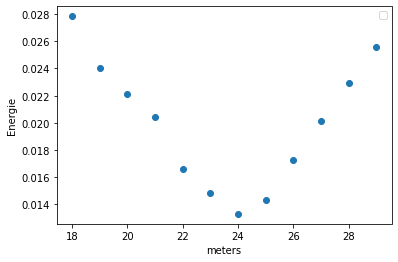

In [7]:
list_test = []
list_speeds = []
plt.figure()



for i in range(18,30):
    infl = func1D(i)
    print("Speed :",i*3.6)
    print(get_energie(infl,i))
    list_test.append(get_energie(infl,i))
    list_speeds.append(i)
plt.plot(list_speeds,list_test,'o')
plt.xlabel("meters")
plt.ylabel("Energie")
plt.legend()
plt.show()
    

In [8]:
#interpoler cette fonction puis multplier le coefficient (ou l'inverse..) à la ligne d'influence 

### II.3 Interpolation de cette fonction (énergie/metres)

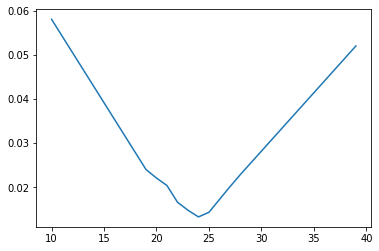

In [9]:
energie_interp = interp1d(list_speeds, list_test, fill_value="extrapolate",axis=0)#permet à partir de meters et infuence de trouver une approximation de influence = f(meters)
plt.figure()
list_ener = []
for i in range(10,40):
    #print(energie_interp(i))
    list_ener.append(energie_interp(i))
list_ener = np.array(list_ener)
    
plt.plot(np.arange(10,40),list_ener,)
    
plt.show()
    

### II.4 LI en fonction des vitesses (avec la fonction interpolée)

0.027843494999006634
0.024056362995984928
0.022121268525334123
0.020418795632680165
0.016643654186652652
0.0148157829697422
0.013304285878230532
0.014354035411790141


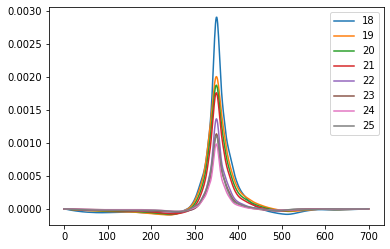

In [10]:
plt.figure()
for i in range(18,26):
    infl = func1D(i)
    ener = energie_interp(i)
    plt.plot((ener)*infl,label=str(i))

    print(ener)
plt.legend()

## III/ Autres tests

In [11]:

calibration_trucks,traffic_trucks = load_senlis_modified(selected=6) #[3,4,6,7]
trucks = [truck for truck in calibration_trucks if(len(truck.weights) == len(truck.peaks))]
trucks_t = [truck for truck in traffic_trucks if(len(truck.weights) == len(truck.peaks))]

infl=calibration_mt(trucks,l2_reg={'strength': 1e3, 'cutoff': 0.01},tv_reg={'strength': 1e3, 'cutoff': 0.95})


In [12]:
def distance_eucli(signal1,signal2):
    return(np.linalg.norm(signal2-signal1))

0.2316701386325156
0.19462121428023488
0.1783690314976151
0.16460261365146897
0.1264816434932767
0.11668807218072577
0.11253887028777584
0.11724643985374449


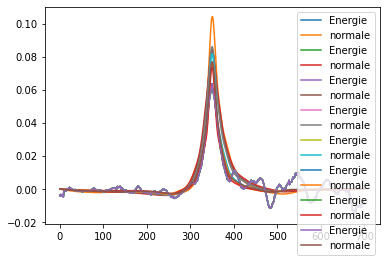

Distance eucli moyenne :  1.2422180238773575


In [13]:
plt.figure()
distance_moy = 0
for i in range(18,26):
    infl_interp = func1D(i)
    ener = energie_interp(i)
    plt.plot((1-ener)*infl,label='Energie')
    plt.plot(infl_interp,label='normale')

    print(distance_eucli((1-ener)*infl,infl_interp))
    distance_moy += distance_eucli((1-ener)*infl,infl_interp)
plt.legend()
plt.show()
print("Distance eucli moyenne : ",distance_moy)

Speed :  24.380991984594182


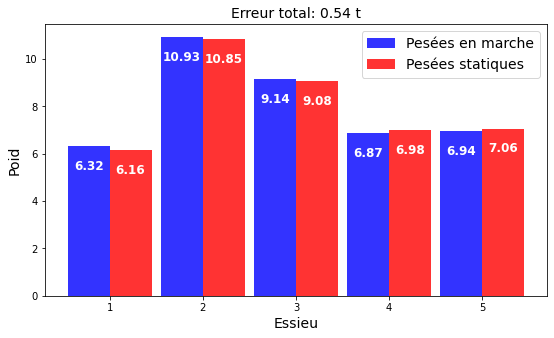

Distance euclidienne avec l'interpolée :  0.10662370184588478
Speed :  23.272699098967962


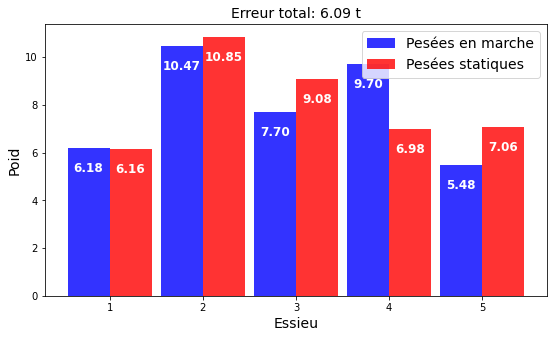

Distance euclidienne avec l'interpolée :  0.11548431214917525
Speed :  23.630769230769232


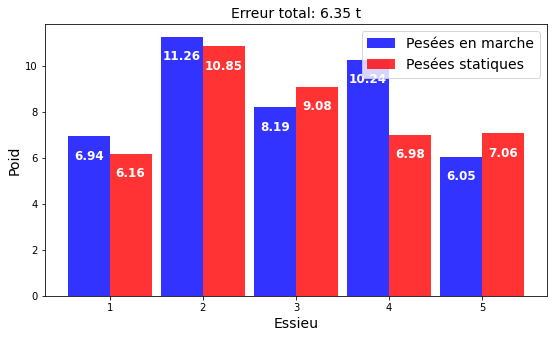

Distance euclidienne avec l'interpolée :  0.11609926706625671
Speed :  24.00002912772182


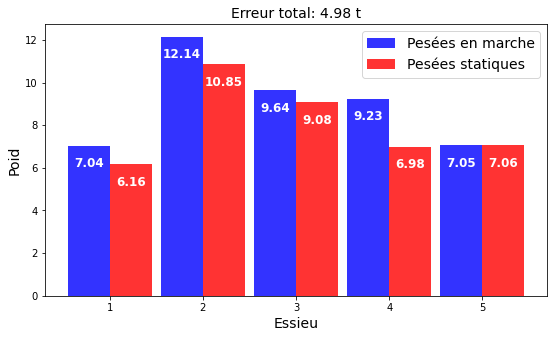

Distance euclidienne avec l'interpolée :  0.10694394255127265
Speed :  21.63376871440886


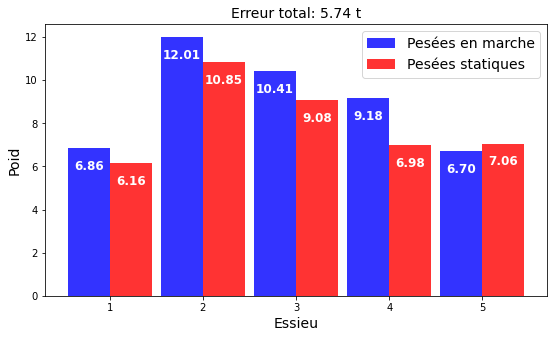

Distance euclidienne avec l'interpolée :  0.13008054325843402
Speed :  23.630778718660313


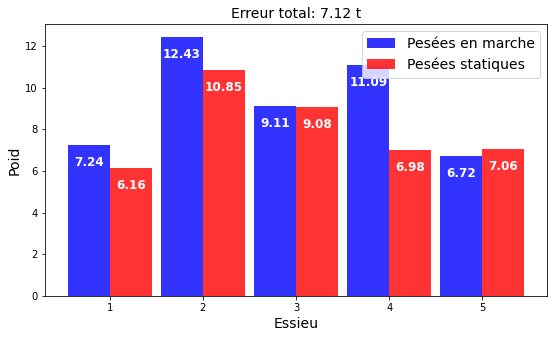

Distance euclidienne avec l'interpolée :  0.1284218093010656
Speed :  18.731689060807692


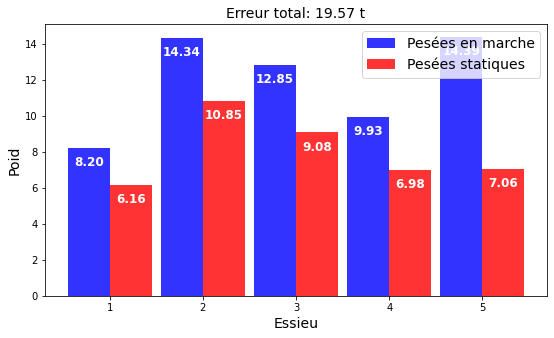

Distance euclidienne avec l'interpolée :  0.19832829038444136
Speed :  18.963018634210332


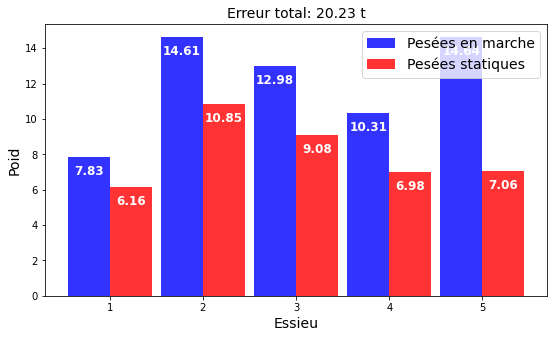

Distance euclidienne avec l'interpolée :  0.20380479540125798
Speed :  18.50599705565925


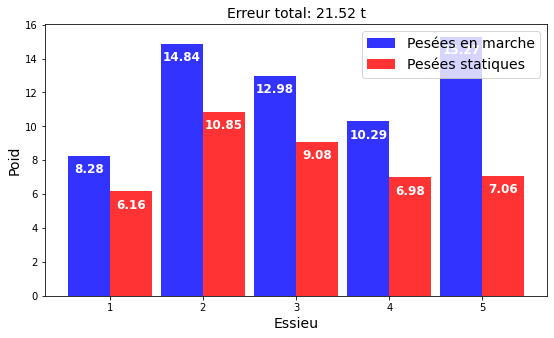

Distance euclidienne avec l'interpolée :  0.20823102292714954
Speed :  21.333341568157582


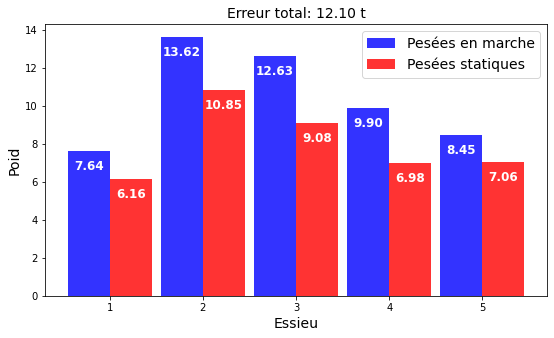

Distance euclidienne avec l'interpolée :  0.15757390858232145
Speed :  18.96294211024312


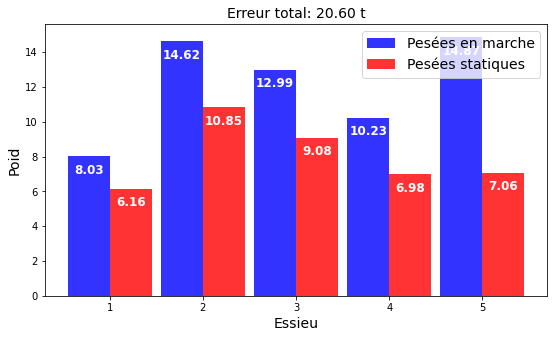

Distance euclidienne avec l'interpolée :  0.2062861639899422
Erreur moyenne  11.350194970053865
Erreur max :  21.515431875301523
% erreur moyen :  -0.2546243620217936


In [14]:
somme=0
max_error = 0
percent_error = 0
for i,truck in enumerate(trucks):
    ener = (1-energie_interp(i))
    print("Speed : ",truck.speed)
    #infl = func1D(truck.speed)
    #infl=calibration_mt(trucks[i:i+1],l2_reg={'strength': 1e3, 'cutoff': 0.01},tv_reg={'strength': 1e3, 'cutoff': 0.95})
    final_infl =0
    if(truck.speed>21):
        final_infl = infl
    else:
        final_infl = ener*infl
    w = estimation(truck,final_infl)
    percent_error += 1-(np.sum(w)/np.sum(truck.weights))
    if(max_error<np.sum(abs(truck.weights -w))):
        
        max_error = np.sum(abs(truck.weights -w))
    somme = np.sum(abs(truck.weights -w))+somme
    compare_weights(w, truck.weights)
    print("Distance euclidienne avec l'interpolée : ",distance_eucli(final_infl,func1D(truck.speed)))
print("Erreur moyenne " ,somme/len(trucks))
print("Erreur max : ",max_error)
print("% erreur moyen : ",percent_error/len(trucks))

Speed :  24.380991984594182


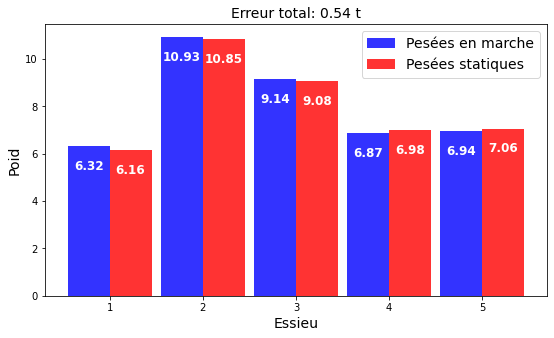

Speed :  23.272699098967962


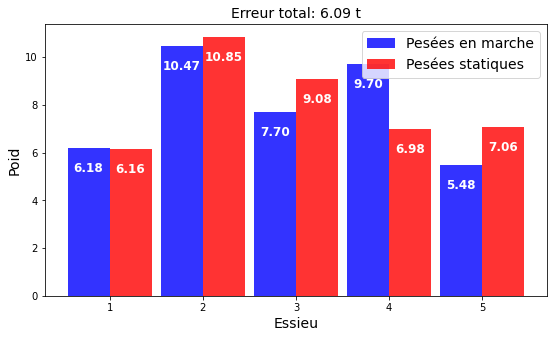

Speed :  23.630769230769232


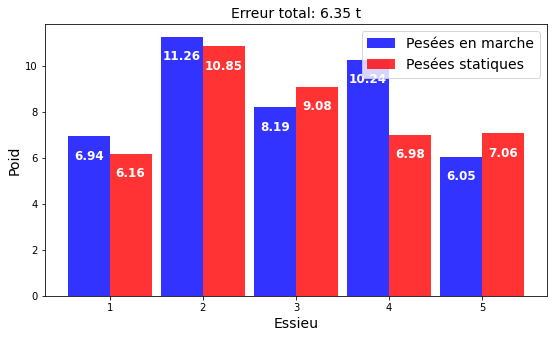

Speed :  24.00002912772182


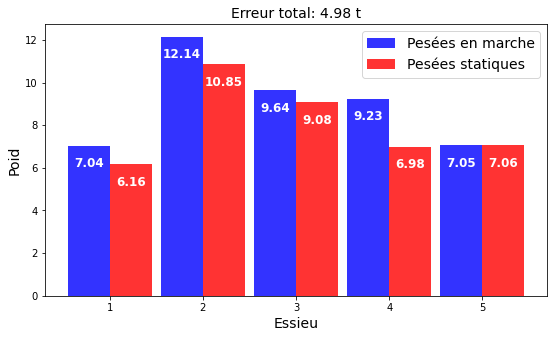

Speed :  21.63376871440886


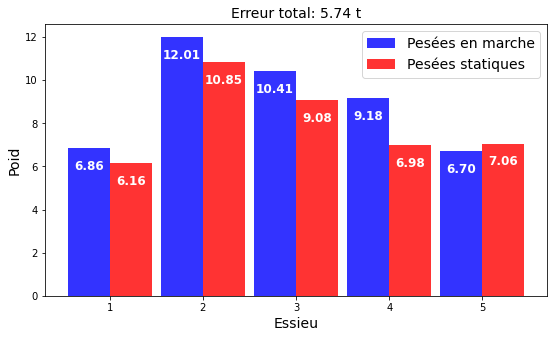

Speed :  23.630778718660313


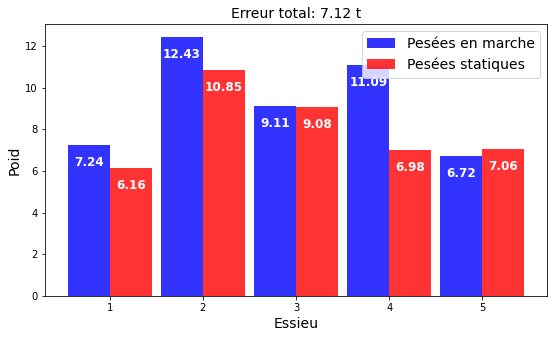

Speed :  18.731689060807692


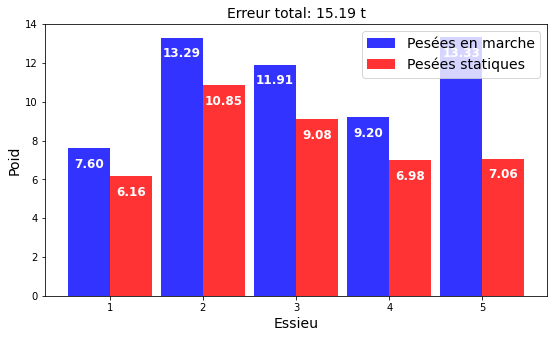

Speed :  18.963018634210332


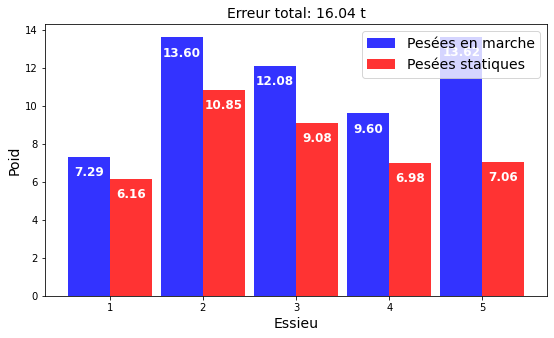

Speed :  18.50599705565925


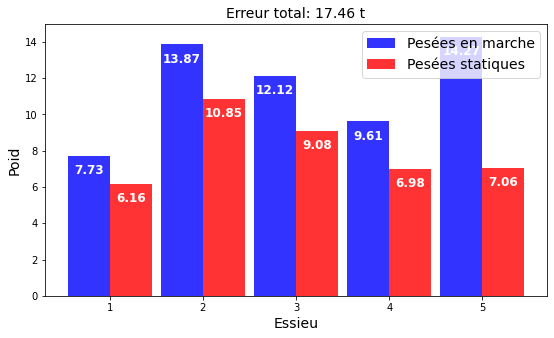

Speed :  21.333341568157582


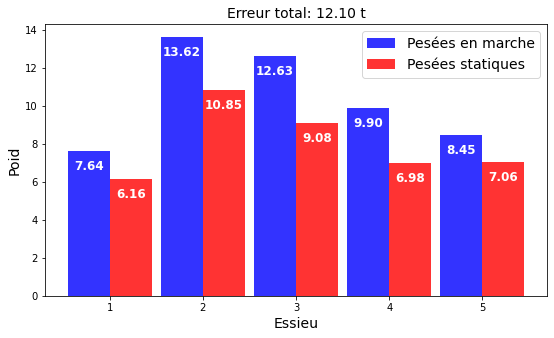

Speed :  18.96294211024312


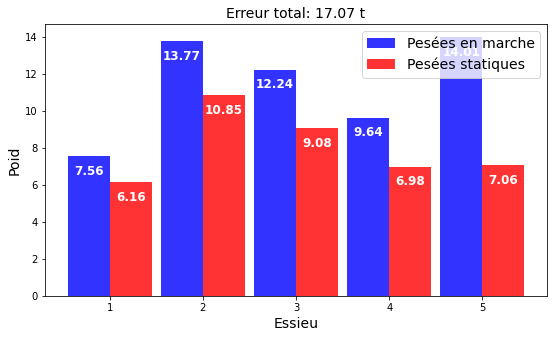

Erreur moyenne  9.881462227669514
Erreur max :  17.463588344142643
% erreur moyen :  -0.21803644280626894


In [15]:

somme=0
max_error = 0
percent_error = 0
for i,truck in enumerate(trucks):
    ener = (1-energie_interp(i))
    print("Speed : ",truck.speed)
    #infl = func1D(truck.speed)
    #infl=calibration_mt(trucks[i:i+1],l2_reg={'strength': 1e3, 'cutoff': 0.01},tv_reg={'strength': 1e3, 'cutoff': 0.95})
    w = estimation(truck,infl)
    percent_error += 1-(np.sum(w)/np.sum(truck.weights))
    if(max_error<np.sum(abs(truck.weights -w))):
        
        max_error = np.sum(abs(truck.weights -w))    
    somme = np.sum(abs(truck.weights -w))+somme
    compare_weights(w, truck.weights)
print("Erreur moyenne " ,somme/len(trucks))
print("Erreur max : ",max_error)
print("% erreur moyen : ",percent_error/len(trucks))

**A partir de la LI 70km/h**

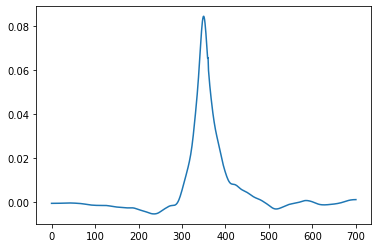

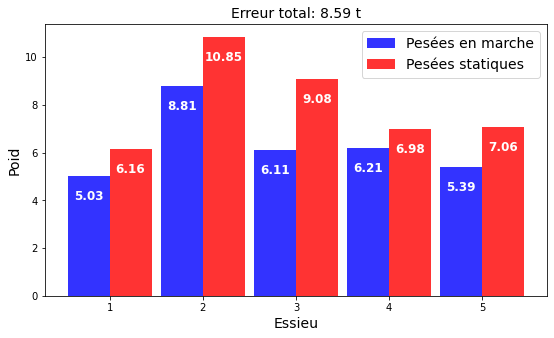

Poids total mesuré : 27.87475006079338
Poids total réel 40.14256


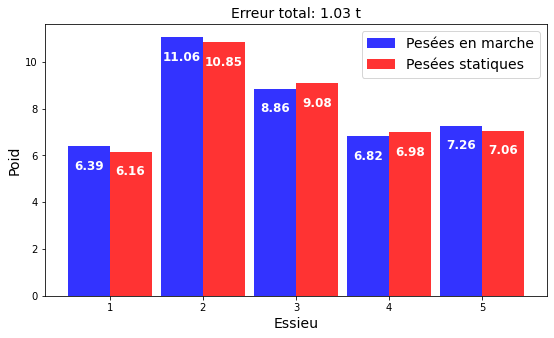

Poids total mesuré : 39.82750230969578
Poids total réel 40.14256


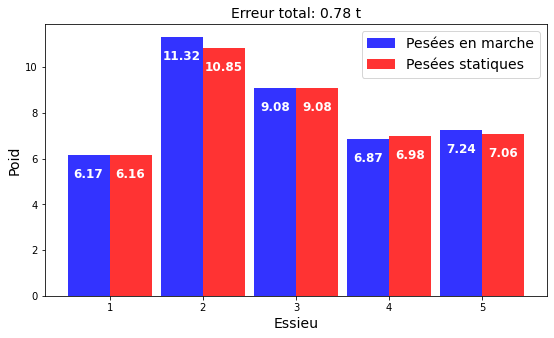

Poids total mesuré : 39.767984148699824
Poids total réel 40.14256


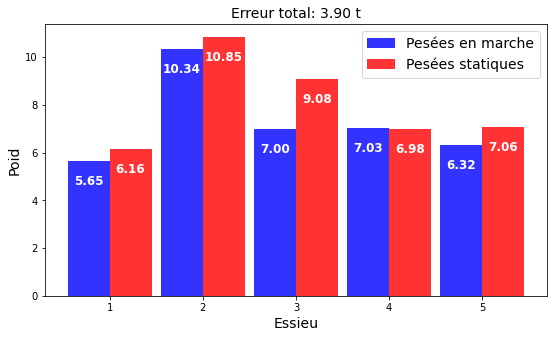

Poids total mesuré : 33.90480425951503
Poids total réel 40.14256


In [16]:

def poids_tot(truck,influence):

    return (np.sum(truck.signals)/np.sum(influence))
capteurs = [6]
calibration_trucks,traffic_trucks = load_senlis_modified(selected=6) #[3,4,6,7]
trucks = [truck for truck in calibration_trucks if(len(truck.peaks)==len(truck.weights))]
h_6 = lignes_influence_mt_speed(70,capteurs,tv_reg={'strength': 1e2, 'cutoff': 0.95})
#multi_viz_speed(70,h_6,capteurs)
h_6 = h_6[0]
plt.plot(h_6)

for i,truck in enumerate(trucks):
    if(truck.speed <19):
        truck = calibration_trucks[i]
        w = estimation(truck, h_6)
        compare_weights(w, truck.weights)
        print("Poids total mesuré :",poids_tot(truck,h_6))
        print("Poids total réel", np.sum(truck.weights))

Speed :  24.380991984594182


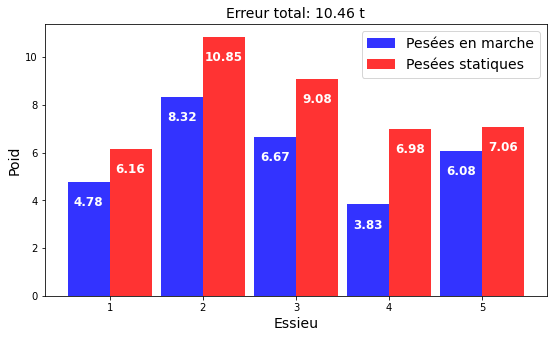

Speed :  23.272699098967962


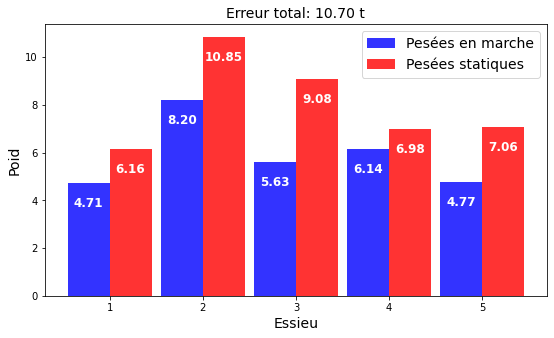

Speed :  23.630769230769232


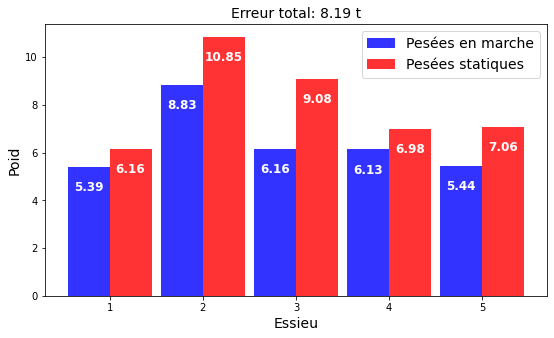

Speed :  24.00002912772182


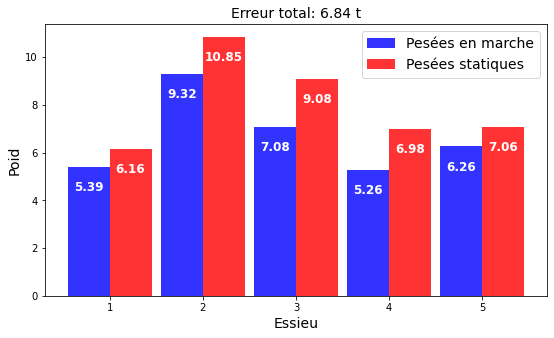

Speed :  21.63376871440886


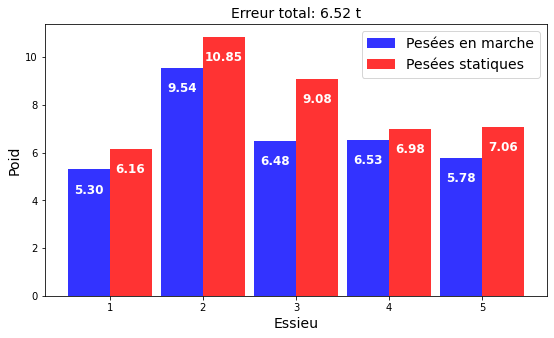

Speed :  23.630778718660313


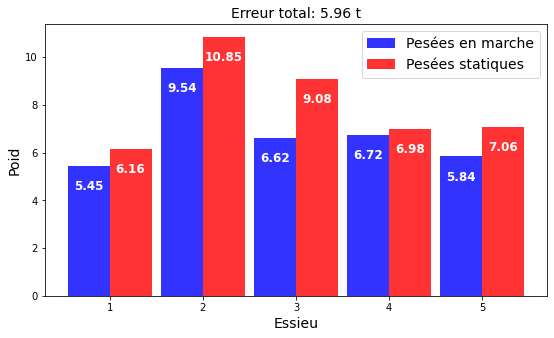

Speed :  18.731689060807692


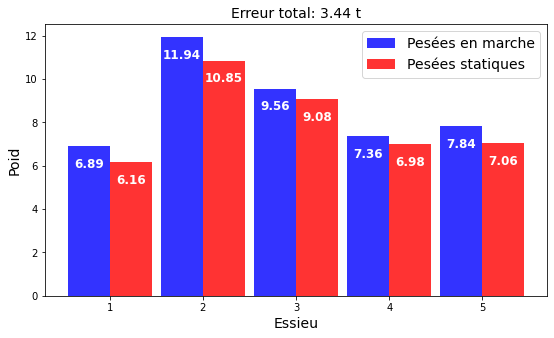

Speed :  18.963018634210332


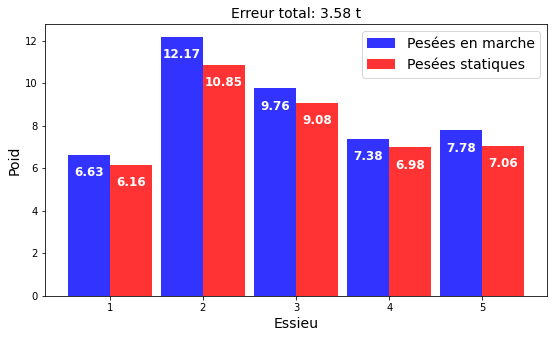

Speed :  18.50599705565925


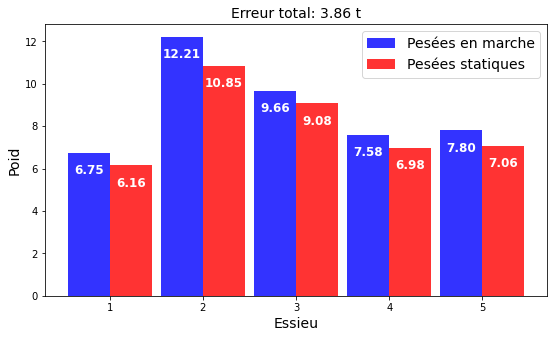

Speed :  21.333341568157582


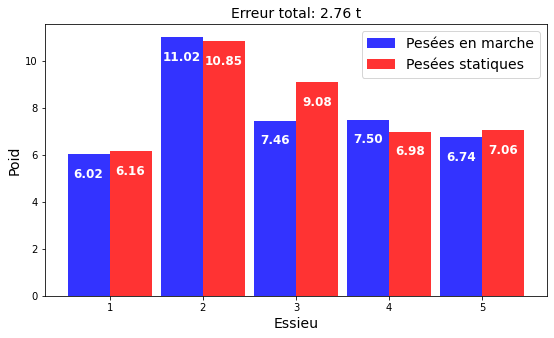

Speed :  18.96294211024312


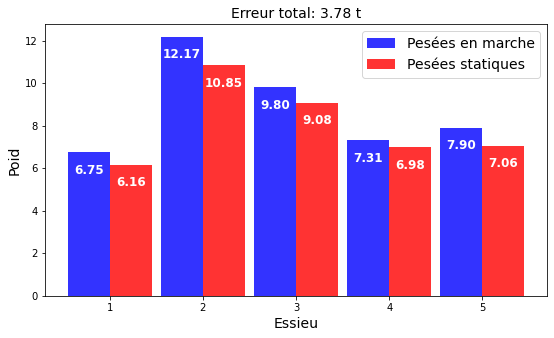

Erreur moyenne  6.007686158232944
Erreur max :  10.695658895144552
% erreur moyen :  0.08016750921979779


In [17]:

somme=0
max_error = 0
percent_error = 0
for i,truck in enumerate(trucks):
    ener =(1-energie_interp(i))
    print("Speed : ",truck.speed)
    #infl = func1D(truck.speed)
    #infl=calibration_mt(trucks[i:i+1],l2_reg={'strength': 1e3, 'cutoff': 0.01},tv_reg={'strength': 1e3, 'cutoff': 0.95})
    final_infl =0

    final_infl = ener*h_6
    w = estimation(truck,final_infl)
    percent_error += 1-(np.sum(w)/np.sum(truck.weights))
    if(max_error<np.sum(abs(truck.weights -w))):
        
        max_error = np.sum(abs(truck.weights -w))
    somme = np.sum(abs(truck.weights -w))+somme
    compare_weights(w, truck.weights)
print("Erreur moyenne " ,somme/len(trucks))
print("Erreur max : ",max_error)
print("% erreur moyen : ",percent_error/len(trucks))